In [ ]:
pip install qiskit==0.43.1 qiskit-machine-learning==0.5.0 torch==2.1.2 torchvision==0.16.2 medmnist==2.0.2 sympy==1.13.1 protobuf==4.25.3 pillow==10.2.0 matplotlib "numpy < 1.24"


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:

In [ ]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
import torch.nn as nn
import panda as pd
from torchvision import transforms
from medmnist import BreastMNIST, INFO
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
# 1. Cấu hình QNN
n_qubits = 6
feature_map = ZZFeatureMap(feature_dimension=n_qubits)
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


<ipython-input-2-31b6b4d01926>:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


In [ ]:
# 2. Khởi tạo QNN đúng cách (positional)
qnn = TwoLayerQNN(n_qubits, feature_map, ansatz, quantum_instance=qi)


In [ ]:
# 3. Kết nối với PyTorch
model = TorchConnector(qnn)


In [ ]:
print("=== BẮT ĐẦU CHƯƠNG TRÌNH ===")

# Tải dataset BreastMNIST
transform = transforms.Compose([
    transforms.Resize((8, 8)),  # giảm kích thước ảnh về 8x8 = 64 pixel
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

data = BreastMNIST(split='train', transform=transform, download=True)
loader = DataLoader(data, batch_size=1, shuffle=True)

# Dùng 6 qubit đầu tiên (ví dụ)
n_qubits = 6

# Chuyển ảnh thành vector input 6 chiều (giản lược)
def get_input_vector(image):
    flat = image.flatten()
    return flat[:n_qubits]  # lấy 6 giá trị đầu

# Xây QNN
feature_map = ZZFeatureMap(feature_dimension=n_qubits)
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)
qnn = TwoLayerQNN(n_qubits, feature_map, ansatz, quantum_instance=qi)

# Dùng QNN như một tầng torch
model = TorchConnector(qnn)

# Huấn luyện đơn giản với torch
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(3):
    for img, label in loader:
        x = get_input_vector(img).float()
        y = torch.tensor([[float(label[0])]], dtype=torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {loss.item():.4f}")

print("=== ĐÃ HẾT CHƯƠNG TRÌNH ===")
# Đánh giá mô hình sau huấn luyện
y_true = []
y_pred = []
imgs_to_plot = []

for img, label in loader:
    x = get_input_vector(img).float()
    pred = model(x)
    pred_label = int(pred.item() > 0.5)
    y_true.append(int(label[0]))
    y_pred.append(pred_label)
    if len(imgs_to_plot) < 10:
        imgs_to_plot.append((img, pred_label, int(label[0])))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

input("Ấn Enter để thoát...")



=== BẮT ĐẦU CHƯƠNG TRÌNH ===
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Epoch 1 loss: 0.7740
Epoch 2 loss: 0.3012
Epoch 3 loss: 0.3371

=== Evaluation Metrics ===
Accuracy : 0.3864
Precision: 0.8077
Recall   : 0.2105
F1 Score : 0.3340
Ấn Enter để thoát...


''

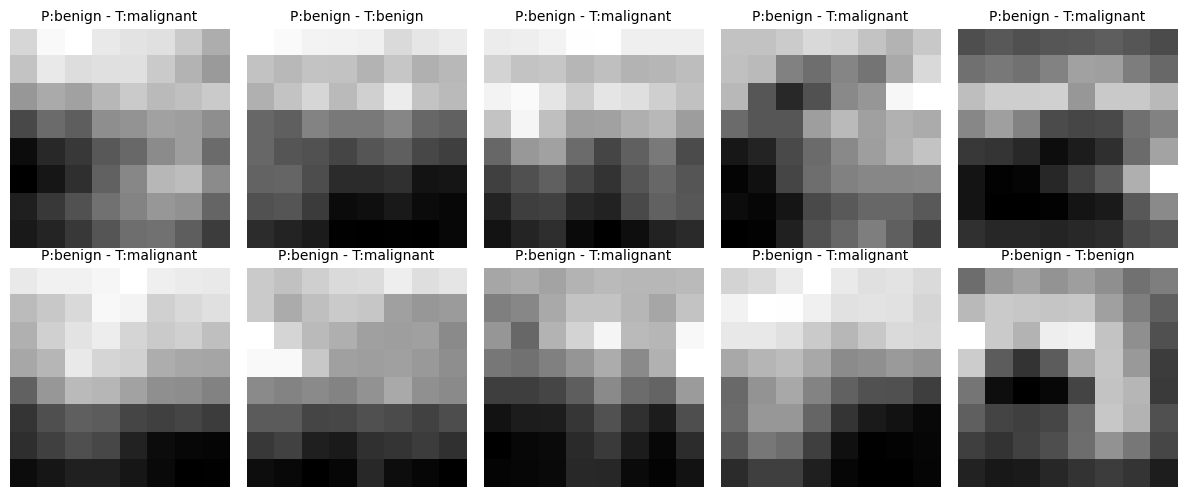

In [ ]:
# Hiển thị các ảnh phân loại mẫu
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

# Define a mapping for labels
label_mapping = {0: "benign", 1: "malignant"}

for i, (img, pred_label, true_label) in enumerate(imgs_to_plot):
    # Squeeze the image tensor to remove batch and channel dimensions, then convert to numpy
    img_display = img.squeeze(0).squeeze(0).numpy()
    # Sử dụng interpolation='nearest' để hiển thị rõ các pixel vuông
    axs[i].imshow(img_display, cmap="gray", interpolation='nearest')

    # Get the descriptive labels
    pred_label_text = label_mapping.get(pred_label, str(pred_label))
    true_label_text = label_mapping.get(true_label, str(true_label))

    axs[i].set_title(f"P:{pred_label_text} - T:{true_label_text}", fontsize=10)
    axs[i].axis("off")

plt.tight_layout()
plt.show()